In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelado y Forecasting
# ==============================================================================
import xgboost
import lightgbm
import catboost
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap

c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
import sys
import os
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root 

In [3]:
ruta_df = root.DIR_DATA_STAGE + 'merged_df_consumption.csv'
datos = pd.read_csv(ruta_df)

In [4]:
datos['datetime'] = pd.to_datetime(datos['datetime'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('datetime')
datos = datos.asfreq('h')
## filtrar los primeros 3 dias que continenen gran cantidad de datos nulos
#datos_3_dias = datos.loc[datos.index[:'2021-10-03']]


In [5]:
datos.tail()

,date,target,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,...,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,eic_count,installed_capacity
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-31 19:00:00,2023-05-31,8645.581,11.28,0.90,0.0,0.0,1015.05,50.2,0.0,58.1,...,4.588889,282.8,230.6,154.6,76.0,29.0,34.0,8.57,482.0,19314.31
2023-05-31 20:00:00,2023-05-31,9204.993,10.37,1.18,0.0,0.0,1015.03,48.6,0.0,68.1,...,4.022222,277.3,107.8,48.5,59.3,29.0,34.0,8.57,482.0,19314.31
2023-05-31 21:00:00,2023-05-31,9101.662,9.75,1.42,0.0,0.0,1014.85,60.2,0.0,83.2,...,3.775000,273.0,27.4,7.1,20.3,29.0,34.0,8.57,482.0,19314.31
2023-05-31 22:00:00,2023-05-31,8580.003,8.92,1.67,0.0,0.0,1015.02,59.3,0.0,83.2,...,3.727778,271.8,0.0,0.0,0.0,29.0,34.0,8.57,482.0,19314.31
2023-05-31 23:00:00,2023-05-31,7785.862,8.54,1.75,0.0,0.0,1015.03,72.2,0.0,88.8,...,3.613889,271.5,0.0,0.0,0.0,29.0,34.0,8.57,482.0,19314.31


imputamos los datos faltantes de la variable target mediante un forwardfill

In [6]:
datos['target'] = datos['target'].ffill()

## Train, Validation y test split

In [7]:
# Separación de datos en entrenamiento, validación y test
# ==============================================================================
fin_train = '2022-08-31 23:59:00'
fin_validacion = '2023-01-31 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]
print(
    f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  "
    f"(n={len(datos_train)})"
)
print(
    f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  "
    f"(n={len(datos_val)})"
)
print(
    f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  "
    f"(n={len(datos_test)})"
)

Fechas train      : 2021-09-01 00:00:00 --- 2022-08-31 23:00:00  (n=8760)
Fechas validación : 2022-09-01 00:00:00 --- 2023-01-31 23:00:00  (n=3672)
Fechas test       : 2023-02-01 00:00:00 --- 2023-05-31 23:00:00  (n=2880)


In [8]:
# Gráfico interactivo de la serie temporal
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=datos_train.index, y=datos_train['target'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=datos_val.index, y=datos_val['target'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test['target'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Consumo de energía Electrica',
    xaxis_title="Fecha",
    yaxis_title="kWh",
    legend_title="Partición:",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

# EDA

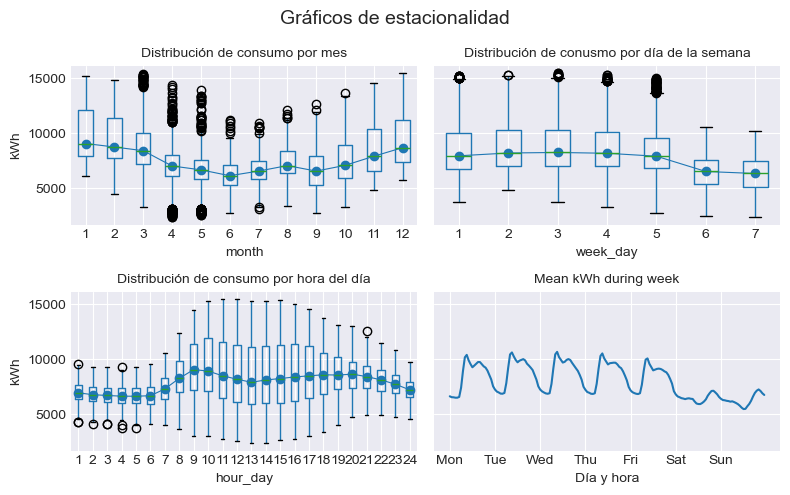

In [9]:
# Estacionalidad anual, semanal y diaria
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Distribusión de usuarios por mes
datos['month'] = datos.index.month
datos.boxplot(column='target', by='month', ax=axs[0])
datos.groupby('month')['target'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('kWh')
axs[0].set_title('Distribución de consumo por mes', fontsize=10)

# Distribusión de usuarios por día de la semana
datos['week_day'] = datos.index.day_of_week + 1
datos.boxplot(column='target', by='week_day', ax=axs[1])
datos.groupby('week_day')['target'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('kWh')
axs[1].set_title('Distribución de conusmo por día de la semana', fontsize=10)

# Distribusión de usuarios por hora del día
datos['hour_day'] = datos.index.hour + 1
datos.boxplot(column='target', by='hour_day', ax=axs[2])
datos.groupby('hour_day')['target'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('kWh')
axs[2].set_title('Distribución de consumo por hora del día', fontsize=10)

# Distribusión de usuarios por día de la semana y hora del día
mean_day_hour = datos.groupby(["week_day", "hour_day"])["target"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean kWh during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Día y hora",
    ylabel      = "kWh"
)
axs[3].title.set_size(10)

fig.suptitle("Gráficos de estacionalidad", fontsize=14)
fig.tight_layout()

## Analisis de autocorrelacion

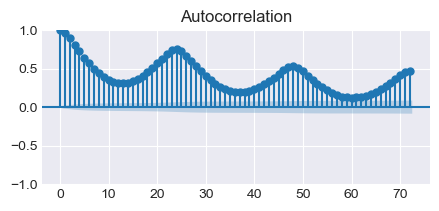

In [10]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(datos['target'].dropna(), ax=ax, lags=72)
plt.show()

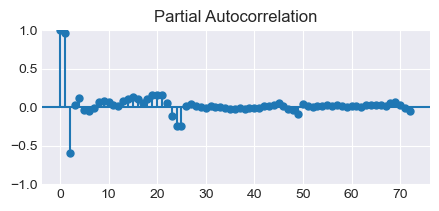

In [11]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(datos['target'].dropna(), ax=ax, lags=72, method='ywm')
plt.show()

podemos observar que la serie tiene una estacionalidad dada cada 24 lags aproximadamente

## Modelo Baseline

In [12]:
# Crear un baseline: valor de la misma hora del día anterior
# ==============================================================================
forecaster = ForecasterEquivalentDate(
    offset    = pd.DateOffset(days=1),
    n_offsets = 1
)

# Entremaiento del forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'target'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2021-09-01 00:00:00'), Timestamp('2023-01-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2024-11-11 16:42:00 
Last fit date: 2024-11-11 16:42:00 
Skforecast version: 0.13.0 
Python version: 3.10.15 
Forecaster id: None 

In [13]:
# Backtesting
# ==============================================================================
metrica_baseline, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['target'],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos.loc[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_baseline

100%|██████████| 80/80 [00:00<00:00, 214.25it/s]


,mean_absolute_error
0,1366.32169


el error con el modelo baseline es de 1366.3

# Modelo autoregresivo recursivo con LightGBM

Se crea un modelo con LGBM utilizando 24 lags

In [14]:
# Crear el forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=15926, verbose=-1),
    lags      = 24
)

# Entrenar el forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'target'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2021-09-01 00:00:00'), Timestamp('2023-01-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-11 16

In [15]:
forecaster.predict(steps=10)

2023-02-01 00:00:00     7713.905482
2023-02-01 01:00:00     7522.103171
2023-02-01 02:00:00     7443.902377
2023-02-01 03:00:00     7424.991837
2023-02-01 04:00:00     7490.720529
2023-02-01 05:00:00     7705.415149
2023-02-01 06:00:00     8792.849988
2023-02-01 07:00:00    10735.878078
2023-02-01 08:00:00    12305.334501
2023-02-01 09:00:00    12764.847190
Freq: h, Name: pred, dtype: float64

In [16]:
# Backtest del modelo con lo datos de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['target'],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = True, # Cambiar a False para mostrar menos información
    show_progress      = True
)
predicciones.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12432
Number of observations used for backtesting: 2880
    Number of folds: 80
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2021-09-01 00:00:00 -- 2023-01-31 23:00:00  (n=12432)
    Validation: 2023-02-01 00:00:00 -- 2023-02-02 11:00:00  (n=36)
Fold: 1
    Training:   No training in this fold
    Validation: 2023-02-02 12:00:00 -- 2023-02-03 23:00:00  (n=36)
Fold: 2
    Training:   No training in this fold
    Validation: 2023-02-04 00:00:00 -- 2023-02-05 11:00:00  (n=36)
Fold: 3
    Training:   No training in this fold
    Validation: 2023-02-05 12:00:00 -- 2023-02-06 23:00:00  (n=36)
Fold: 4
    Training:   No training in this fold
    Validation: 2023-02-07 00:00:00 -- 2023-02-08 11:00:00  (n=36)
Fold: 5
    Training:   No training in this f

100%|██████████| 80/80 [00:01<00:00, 44.93it/s]


,pred
2023-02-01 00:00:00,7713.905482
2023-02-01 01:00:00,7522.103171
2023-02-01 02:00:00,7443.902377
2023-02-01 03:00:00,7424.991837
2023-02-01 04:00:00,7490.720529


In [17]:
# Error de backtest
# ==============================================================================
metrica

,mean_absolute_error
0,1253.137649


el error con este modelo aunque mejoro un poco con respecto al baseline sigue siendo muy alto

## busqueda de hiperparametros

In [18]:
# Búsqueda de hiperparámetros
# ==============================================================================
# Lags candidatos
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

resultados_busqueda, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'target'], # Datos test no incluidos
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20, # Aumentar para una búsqueda más exhaustiva
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

Best trial: 16. Best value: 730.143: 100%|██████████| 20/20 [01:01<00:00,  3.08s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1100, 'max_depth': 3, 'min_data_in_leaf': 65, 'learning_rate': 0.18327779070309982, 'feature_fraction': 0.8, 'max_bin': 100, 'reg_alpha': 0.2, 'reg_lambda': 0.0}
  Backtesting metric: 730.1428990720549



In [19]:
# Resultados de la búsqueda
# ==============================================================================
resultados_busqueda.head()

,lags,params,mean_absolute_error,n_estimators,max_depth,min_data_in_leaf,learning_rate,feature_fraction,max_bin,reg_alpha,reg_lambda
16,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1100, 'max_depth': 3, 'min_da...",730.142899,1100.0,3.0,65.0,0.183278,0.8,100.0,0.2,0.0
19,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1100, 'max_depth': 3, 'min_da...",747.033273,1100.0,3.0,176.0,0.055757,0.6,125.0,0.3,0.1
17,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1100, 'max_depth': 3, 'min_da...",774.621003,1100.0,3.0,188.0,0.016834,0.6,125.0,0.3,0.0
18,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 400, 'max_depth': 3, 'min_dat...",780.364584,400.0,3.0,223.0,0.130476,0.6,150.0,0.4,0.0
11,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 10, 'min_d...",781.058015,1200.0,10.0,31.0,0.017627,1.0,50.0,0.0,0.2


In [20]:
# Mejor modelo
# ==============================================================================
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(feature_fraction=0.8, learning_rate=0.18327779070309982,
              max_bin=100, max_depth=3, min_data_in_leaf=65, n_estimators=1100,
              random_state=15926, reg_alpha=0.2, verbose=-1) 
Lags: [  1   2   3  23  24  25 167 168 169] 
Transformer for y: None 
Transformer for exog: None 
Window size: 169 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2021-09-01 00:00:00'), Timestamp('2023-01-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.18327779070309982, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.2, 

corremos el modelo de nuevo ya con lso parametros encontrados

In [21]:
# Backtest modelo final con datos de test
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['target'],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
display(metrica)
predicciones.head()

100%|██████████| 80/80 [00:02<00:00, 33.79it/s]


,mean_absolute_error
0,927.367077


,pred
2023-02-01 00:00:00,7744.373982
2023-02-01 01:00:00,7554.188127
2023-02-01 02:00:00,7405.781104
2023-02-01 03:00:00,7388.322328
2023-02-01 04:00:00,7405.416005


con este nuevo modelo el error si bajo considerablemente

## grafica valores reales vs predichos

In [22]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['target'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="kWh",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

# Usando variables exogenas

realizaremos el mismo procedimiento pero agregando variables exogenas, las que ya teien el dataset y crearemos unas nuevas

In [23]:
# Variables basadas en el calendario
# ==============================================================================
variables_calendario = pd.DataFrame(index=datos.index)
variables_calendario['mes'] = variables_calendario.index.month
variables_calendario['semana_anyo'] = variables_calendario.index.isocalendar().week
variables_calendario['dia_semana'] = variables_calendario.index.day_of_week + 1
variables_calendario['hora_dia'] = variables_calendario.index.hour + 1

In [24]:
# Variables basadas en temperatura
# ==============================================================================
variables_temp = datos[['temperature']].copy()
variables_temp['temp_roll_mean_1_dia'] = variables_temp['temperature'].rolling(24, closed='left').mean()
variables_temp['temp_roll_mean_7_dia'] = variables_temp['temperature'].rolling(24*7, closed='left').mean()

In [25]:
# Merge all exogenous variables
# ==============================================================================
variables_exogenas = pd.concat([
    variables_calendario,
    variables_temp,
], axis=1)

variables_exogenas.head(4)

,mes,semana_anyo,dia_semana,hora_dia,temperature,temp_roll_mean_1_dia,temp_roll_mean_7_dia
datetime,,,,,,,
2021-09-01 00:00:00,9,35,3,1,NaN,NaN,NaN
2021-09-01 01:00:00,9,35,3,2,NaN,NaN,NaN
2021-09-01 02:00:00,9,35,3,3,NaN,NaN,NaN
2021-09-01 03:00:00,9,35,3,4,NaN,NaN,NaN


In [26]:
# Codificación cíclica de las variables de calendario y luz solar
# ==============================================================================
def codificacion_ciclica(datos: pd.Series, longitud_ciclo: int) -> pd.DataFrame:
    """
    Codifica una variable cíclica con dos nuevas variables: seno y coseno.
    Se asume que el valor mínimo de la variable es 0. El valor máximo de la
    variable se pasa como argumento.
      
    Parameters
    ----------
    datos : pd.Series
        Serie con la variable a codificar.
    longitud_ciclo : int
        La longitud del ciclo. Por ejemplo, 12 para meses, 24 para horas, etc.
        Este valor se utiliza para calcular el ángulo del seno y coseno.

    Returns
    -------
    resultado : pd.DataFrame
        Dataframe con las dos nuevas características: seno y coseno.

    """

    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({
                  f"{datos.name}_seno": seno,
                  f"{datos.name}_coseno": coseno
              })

    return resultado


In [27]:
mes_encoded = codificacion_ciclica(variables_exogenas['mes'], longitud_ciclo=12)
semana_anyo_encoded = codificacion_ciclica(variables_exogenas['semana_anyo'], longitud_ciclo=52)
dia_semana_encoded = codificacion_ciclica(variables_exogenas['dia_semana'], longitud_ciclo=7)
hora_dia_encoded = codificacion_ciclica(variables_exogenas['hora_dia'], longitud_ciclo=24)


variables_ciclicas = pd.concat([
                            mes_encoded,
                            semana_anyo_encoded,
                            dia_semana_encoded,
                            hora_dia_encoded,
                        ], axis=1)  

variables_exogenas = pd.concat([variables_exogenas, variables_ciclicas], axis=1)
variables_exogenas.head(3)

,mes,semana_anyo,dia_semana,hora_dia,temperature,temp_roll_mean_1_dia,temp_roll_mean_7_dia,mes_seno,mes_coseno,semana_anyo_seno,semana_anyo_coseno,dia_semana_seno,dia_semana_coseno,hora_dia_seno,hora_dia_coseno
datetime,,,,,,,,,,,,,,,
2021-09-01 00:00:00,9,35,3,1,NaN,NaN,NaN,-1.0,-1.836970e-16,-0.885456,-0.464723,0.433884,-0.900969,0.258819,0.965926
2021-09-01 01:00:00,9,35,3,2,NaN,NaN,NaN,-1.0,-1.836970e-16,-0.885456,-0.464723,0.433884,-0.900969,0.500000,0.866025
2021-09-01 02:00:00,9,35,3,3,NaN,NaN,NaN,-1.0,-1.836970e-16,-0.885456,-0.464723,0.433884,-0.900969,0.707107,0.707107


In [28]:
# Interacción entre variables exógenas
# ==============================================================================
transformer_poly = PolynomialFeatures(
    degree           = 2,
    interaction_only = True,
    include_bias     = False
).set_output(transform="pandas")

poly_cols = ['temperature',
       'temp_roll_mean_1_dia', 'temp_roll_mean_7_dia', 'mes_seno',
       'mes_coseno', 'semana_anyo_seno', 'semana_anyo_coseno',
       'dia_semana_seno', 'dia_semana_coseno', 'hora_dia_seno',
       'hora_dia_coseno']

In [29]:
variables_poly = transformer_poly.fit_transform(variables_exogenas[poly_cols].dropna())
variables_poly = variables_poly.drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
variables_exogenas = pd.concat([variables_exogenas, variables_poly], axis=1)
variables_exogenas.tail(3)

,mes,semana_anyo,dia_semana,hora_dia,temperature,temp_roll_mean_1_dia,temp_roll_mean_7_dia,mes_seno,mes_coseno,semana_anyo_seno,...,poly_semana_anyo_coseno__dia_semana_seno,poly_semana_anyo_coseno__dia_semana_coseno,poly_semana_anyo_coseno__hora_dia_seno,poly_semana_anyo_coseno__hora_dia_coseno,poly_dia_semana_seno__dia_semana_coseno,poly_dia_semana_seno__hora_dia_seno,poly_dia_semana_seno__hora_dia_coseno,poly_dia_semana_coseno__hora_dia_seno,poly_dia_semana_coseno__hora_dia_coseno,poly_hora_dia_seno__hora_dia_coseno
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-31 21:00:00,5,22,3,22,9.75,11.725000,13.369583,0.5,-0.866025,0.464723,...,-0.384185,0.797768,4.427280e-01,-0.766827,-0.390916,-2.169419e-01,0.375754,4.504844e-01,-0.780262,-4.330127e-01
2023-05-31 22:00:00,5,22,3,23,8.92,11.587917,13.344048,0.5,-0.866025,0.464723,...,-0.384185,0.797768,2.291729e-01,-0.855285,-0.390916,-1.122974e-01,0.419100,2.331879e-01,-0.870269,-2.500000e-01
2023-05-31 23:00:00,5,22,3,24,8.54,11.457500,13.320000,0.5,-0.866025,0.464723,...,-0.384185,0.797768,2.168742e-16,-0.885456,-0.390916,-1.062709e-16,0.433884,2.206737e-16,-0.900969,-2.449294e-16


eliminamos las columnas mes, semana, dia u hora dia, debido a que ya se creraron unas nuevas que ademas capturan su comportamiento cicilico

In [30]:
cols_to_drop = ['mes', 'semana_anyo', 'dia_semana', 'hora_dia']

In [31]:
variables_exogenas = variables_exogenas.drop(columns=cols_to_drop)

In [37]:
exog_cols = variables_exogenas.columns

unimos el dataset original con las variables exogenas creadas

In [32]:
# Combinar variables exógenas y target en el mismo dataframe
datos_filtered = datos.drop(columns=['date','temperature'])
# ==============================================================================
datos_final = datos_filtered.merge(
    variables_exogenas,
    left_index=True,
    right_index=True,
    how='left'
)

In [33]:
datos_final_final = datos_final.dropna()
datos_final = datos_final.astype({col: np.float32 for col in datos_final.select_dtypes("number").columns})
datos_final_train = datos_final.loc[: fin_train, :].copy()
datos_final_val   = datos_final.loc[fin_train:fin_validacion, :].copy()
datos_final_test  = datos_final.loc[fin_validacion:, :].copy()

## Ejecucion del modelo

In [34]:
# Búsqueda de hiperparámetros

# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
)

# Lags grid
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos_final.loc[:fin_validacion, 'target'],
    exog               = datos_final.loc[:fin_validacion, variables_exogenas.columns],
    search_space       = search_space,
    steps              = 36,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_train),
    fixed_train_size   = False,
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
best_params = results_search['params'].iat[0]

  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\skforecast\utils\utils.py:450: MissingValuesWarning:

`exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)

Best trial: 0. Best value: 883.964:   5%|▌         | 1/20 [00:04<01:28,  4.65s/it]c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\skforecast\utils\utils.py:450: MissingValuesWarning:

`exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)

Best trial: 1. Best value: 825.085:  10%|█         | 2/20 [00:09<01:23,  4.64s/it]c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\skforecast\utils\utils.py:450: MissingValuesWarning:

`exog` has mis

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 800, 'max_depth': 6, 'min_data_in_leaf': 173, 'learning_rate': 0.21891214041177603, 'feature_fraction': 1.0, 'max_bin': 250, 'reg_alpha': 0.5, 'reg_lambda': 0.6000000000000001}
  Backtesting metric: 756.6376732874406



In [38]:
# Backtesting en los datos de test incluyendo las variables exógenas
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos_final['target'],
    exog               = datos_final[exog_cols],
    steps              = 36,
    metric             = 'mean_absolute_error',
    initial_train_size = len(datos_final[:fin_validacion]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica

c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\skforecast\utils\utils.py:450: MissingValuesWarning:

`exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)

100%|██████████| 80/80 [00:02<00:00, 28.10it/s]


,mean_absolute_error
0,952.205777


apesar de agregar las variables exogenas, el MAE del continuo muy similar al del modelo que no incluia estas variables

In [39]:
# Gráfico predicciones vs valor real
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=datos_test.index, y=datos_test['target'], name="test", mode="lines")
trace2 = go.Scatter(x=predicciones.index, y=predicciones['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Predicción vs valor real en los datos de test",
    xaxis_title="Fecha",
    yaxis_title="Usiarios",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()